# 1. Problem Statement

For a given datapoint find the tags accurately. A datapoint can have one or more number of tags.

# 2. Machine Learning Problem

## 2.1 Data

* There are 20,000 datapoints in the dataset and 12 columns in the dataset.

|Column Name|Description|
|---|---|
|CORPORATE_IDENTIFICATION_NUMBER|     a unique id|
|COMPANY_NAME                   |      name of the company|
|COMPANY_STATUS                 |      status of the company|
|COMPANY_CLASS                  |      class of the company|
|COMPANY_CATEGORY               |      category of the company|
|AUTHORIZED_CAPITAL             |      amount of authorized capital|
|PAIDUP_CAPITAL                 |      amount paid|
|DATE_OF_REGISTRATION           |     date of registration|
|REGISTRAR_OF_COMPANIES         |      registrar of the company|
|PRINCIPAL_BUSINESS_ACTIVITY    |    principal business activity of company (target-variable)|
|REGISTERED_OFFICE_ADDRESS      |      registered address of the company|
|SUB_CATEGORY                   |      sub-category of the company|

## 2.2 Mapping Problem to ML

* It is multilabel classification problem. So a datapoint can have more than one tag at the same time.

### 2.2.1 Performance metric

* **Micro-Averaged F1-Score (Mean F Score)** : The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.
[LINK](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

# 3. EDA

**Importing the libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from nltk.corpus import stopwords
import re,os, random
from sklearn.metrics import f1_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

StopWords = set(stopwords.words('english'))

**Loading the dataset**

In [2]:
df = pd.read_csv("./Q2_data_set.csv")
print(df.shape,"\n")
print("Null in the dataset:\n",df.isnull().sum(axis=0))
print("\nTotal Null value in the dataset: ", df.isnull().sum(axis=0).sum())
df.head()

(20000, 12) 

Null in the dataset:
 CORPORATE_IDENTIFICATION_NUMBER      0
COMPANY_NAME                         0
COMPANY_STATUS                       0
COMPANY_CLASS                        0
COMPANY_CATEGORY                     0
AUTHORIZED_CAPITAL                   0
PAIDUP_CAPITAL                     154
DATE_OF_REGISTRATION                51
REGISTRAR_OF_COMPANIES               0
PRINCIPAL_BUSINESS_ACTIVITY        215
REGISTERED_OFFICE_ADDRESS            1
SUB_CATEGORY                         2
dtype: int64

Total Null value in the dataset:  423


,CORPORATE_IDENTIFICATION_NUMBER,COMPANY_NAME,COMPANY_STATUS,COMPANY_CLASS,COMPANY_CATEGORY,AUTHORIZED_CAPITAL,PAIDUP_CAPITAL,DATE_OF_REGISTRATION,REGISTRAR_OF_COMPANIES,PRINCIPAL_BUSINESS_ACTIVITY,REGISTERED_OFFICE_ADDRESS,SUB_CATEGORY
0,U55101AN2007PTC000082,GOLDEN REST ROOM PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,1000000,100000,26-03-2007,RoC-Chennai,Trading,Golden Rest room Prem Nagar Port Blair Andaman...,Indian Non-Government Company
1,U01111AN2007PTC000087,ANDAMAN AGRO PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,2000000,100000,08/06/07 0:00,RoC-Chennai,Agriculture and Allied Activities,Sadha Bhavan Gurudwara Lane Port Blair Andaman...,Indian Non-Government Company
2,U45201AN2007PTC000086,ANDAMAN NIRMAN PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,2000000,2000000,07/11/07 0:00,RoC-Chennai,Construction,Junglighat Port Blair Andaman and Nicobar Isla...,Indian Non-Government Company
3,U62200AN2007PTC000227,ABLE AVIATION (INDIA) PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,20000000,10000000,20-09-2007,RoC-Chennai,"Transport, storage and Communications","HOUSE NO.M.B-210, PART-II, NEAR INCOME TAX OFF...",Indian Non-Government Company
4,U52190AN1996PTC000053,IMPERIAL AGENCIES PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,2500000,2500000,07/10/96 0:00,RoC-Chennai,Trading,2 Middle Point Port Blair Andaman and Nicobar ...,Indian Non-Government Company


* But in some columns there are no data and it is represented by `-`. Let's find those columns and number of such rows in that column.

In [3]:
def unknown_count(df):
    print("Column Name", " "*(40-15), "`-` count", " "*(5), "Null/NaN/None Count", " "*10, "Total")
    print()
    Total = 0
    for col in df.columns:
        cnt = 0
        for val in df[col].values:
            if val=="-":
                cnt+=1
        null_cnt = df[col].isnull().sum()
        total = cnt+null_cnt
        print(col, " "*(40-len(col)-len(str(cnt))), cnt, 
              " "*(20-len(str(null_cnt))), null_cnt,
              " "*(22-len(str(total))), total)
        Total += total
    print("\nTotal numeber of unknown values in the dataset are: ",Total)
unknown_count(df)

Column Name                           `-` count       Null/NaN/None Count            Total

CORPORATE_IDENTIFICATION_NUMBER          0                     0                       0
COMPANY_NAME                             0                     0                       0
COMPANY_STATUS                           0                     0                       0
COMPANY_CLASS                            0                     0                       0
COMPANY_CATEGORY                         0                     0                       0
AUTHORIZED_CAPITAL                      75                     0                      75
PAIDUP_CAPITAL                        3138                   154                    3292
DATE_OF_REGISTRATION                     0                    51                      51
REGISTRAR_OF_COMPANIES                   0                     0                       0
PRINCIPAL_BUSINESS_ACTIVITY              0                   215                     215
REGISTERED_OFFICE_

There are 3636 Unknow values in the dataset.
* Let's see the `AUTHORIZED_CAPITAL` and `PAIDUP_CAPITAL` columns first.
* There are only two rows where `SUB_CATEGORY` is NaN, so drop those two rows.

**AUTHORIZED_CAPITAL**

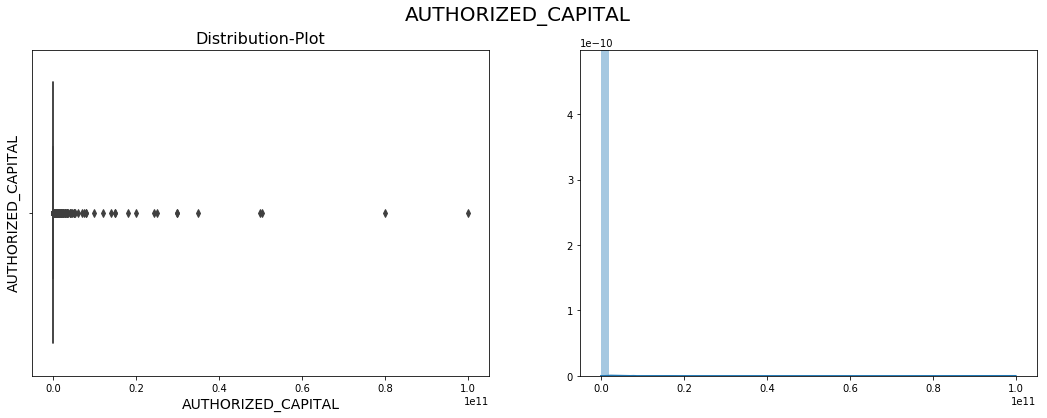

Quantiles are: 
1th Percentile: 100,000.0
25th Percentile: 100,000.0
50th Percentile: 500,000.0
75th Percentile: 2,500,000.0
100th Percentile: 100,000,000,000.0

Percentiles are: (90-100)
90th Percentile: 20,000,000.0
91th Percentile: 20,000,000.0
92th Percentile: 30,000,000.0
93th Percentile: 35,000,000.0
94th Percentile: 50,000,000.0
95th Percentile: 50,000,000.0
96th Percentile: 75,000,000.0
97th Percentile: 100,000,000.0
98th Percentile: 160,000,000.0
99th Percentile: 367,599,999.99998397
100th Percentile: 100,000,000,000.0

Percentiles are: (99-100)
99.1th Percentile: 400,000,000.0
99.2th Percentile: 483,040,000.0000009
99.3th Percentile: 500,000,000.0
99.4th Percentile: 600,000,000.0
99.5th Percentile: 772,850,000.0000076
99.6th Percentile: 1,000,000,000.0
99.7th Percentile: 1,250,000,000.0
99.8th Percentile: 2,732,159,999.999858
99.9th Percentile: 6,076,000,000.000932
100.0th Percentile: 100,000,000,000.0


In [4]:
indices = []
for i in range(len(df)):
    if df.loc[i, 'AUTHORIZED_CAPITAL'] == '-':
        indices.append(i)
ls = df[df["AUTHORIZED_CAPITAL"].isnull()].index.tolist()
indices.extend(ls)
a = df["AUTHORIZED_CAPITAL"].drop(index=indices).values
a = a.astype(float)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,6))
fig.suptitle('AUTHORIZED_CAPITAL', fontsize=20)

sns.boxplot(a, ax=ax1)
ax1.set_title("Box-Plot", fontsize=16)
ax1.set_xlabel("value", fontsize=14)
ax1.set_ylabel("AUTHORIZED_CAPITAL", fontsize=14)

sns.distplot(a, ax=ax2)
ax1.set_title("Distribution-Plot", fontsize=16)
ax1.set_xlabel("AUTHORIZED_CAPITAL", fontsize=14)
plt.show()

print("Quantiles are: ")
for i in [1,25,50,75,100]:
    print("{}th Percentile: {:,}".format(i, np.percentile(a, i)))
    
print("\nPercentiles are: (90-100)")
for i in range(90,101,1):
    print("{}th Percentile: {:,}".format(i, np.percentile(a, i)))
    
print("\nPercentiles are: (99-100)")
for i in range(1,11,1):
    print("{}th Percentile: {:,}".format(i/10+99, np.percentile(a, i/10+99)))

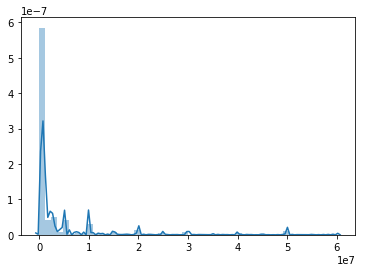

In [5]:
a.sort()
sns.distplot(a[10:19000])
plt.show()

* Above plot is highly skewed (left/negative).
* It's value is varies from 100,000 to 100,000,000,000.
* I am going to drop this feature.

**PAIDUP_CAPITAL**

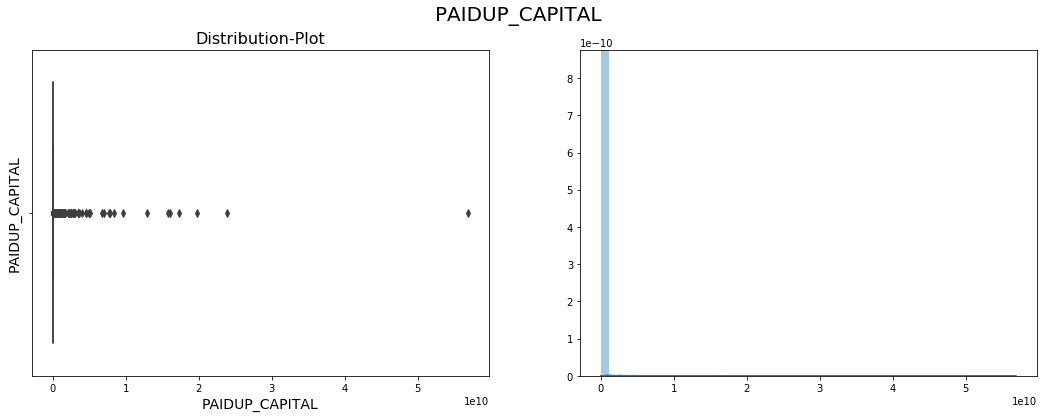

Quantiles are: 
1th Percentile: 300.0
25th Percentile: 100,000.0
50th Percentile: 100,000.0
75th Percentile: 1,394,750.0
100th Percentile: 56,898,462,000.0

Percentiles are: (90-100)
90th Percentile: 13,907,540.000000035
91th Percentile: 16,775,809.000000011
92th Percentile: 20,062,559.200000003
93th Percentile: 26,750,375.000000037
94th Percentile: 35,000,000.0
95th Percentile: 45,252,594.99999999
96th Percentile: 60,000,000.0
97th Percentile: 86,404,727.99999982
98th Percentile: 137,104,288.64000022
99th Percentile: 299,955,900.0000002
100th Percentile: 56,898,462,000.0

Percentiles are: (99-100)
99.1th Percentile: 326,888,316.6899999
99.2th Percentile: 357,875,944.280003
99.3th Percentile: 401,077,226.7299939
99.4th Percentile: 484,611,460.0000006
99.5th Percentile: 561,732,125.0000006
99.6th Percentile: 757,321,983.9999974
99.7th Percentile: 999,889,465.2900008
99.8th Percentile: 2,094,542,159.619905
99.9th Percentile: 4,473,949,464.090018
100.0th Percentile: 56,898,462,000.0


In [6]:
indices = []
for i in range(len(df)):
    if df.loc[i, 'PAIDUP_CAPITAL'] == '-':
        indices.append(i)
ls = df[df["PAIDUP_CAPITAL"].isnull()].index.tolist()
indices.extend(ls)
a = df["PAIDUP_CAPITAL"].drop(index=indices).values
a = a.astype(float)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(18,6))
fig.suptitle('PAIDUP_CAPITAL', fontsize=20)

sns.boxplot(a, ax=ax1)
ax1.set_title("Box-Plot", fontsize=16)
ax1.set_xlabel("value", fontsize=14)
ax1.set_ylabel("PAIDUP_CAPITAL", fontsize=14)

sns.distplot(a, ax=ax2)
ax1.set_title("Distribution-Plot", fontsize=16)
ax1.set_xlabel("PAIDUP_CAPITAL", fontsize=14)
plt.show()

print("Quantiles are: ")
for i in [1,25,50,75,100]:
    print("{}th Percentile: {:,}".format(i, np.percentile(a, i)))
    
print("\nPercentiles are: (90-100)")
for i in range(90,101,1):
    print("{}th Percentile: {:,}".format(i, np.percentile(a, i)))
    
print("\nPercentiles are: (99-100)")
for i in range(1,11,1):
    print("{}th Percentile: {:,}".format(i/10+99, np.percentile(a, i/10+99)))

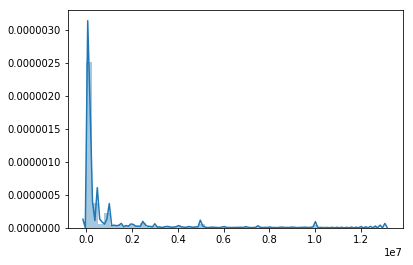

In [7]:
a.sort()
sns.distplot(a[10:15000])
plt.show()

* Above plot is highly skewed (left/negative).
* It's value is varies from 300 to 56,898,462,000.
* I am going to drop this feature.

**Drop Unwanted Columns and rows**

Let's drop the `CORPORATE_IDENTIFICATION_NUMBER`, `REGISTERED_OFFICE_ADDRESS`, `PAIDUP_CAPITAL`, and `AUTHORIZED_CAPITAL` column because it is NOT useful column.

In [8]:
df.drop(["CORPORATE_IDENTIFICATION_NUMBER", "REGISTERED_OFFICE_ADDRESS", "PAIDUP_CAPITAL", 
         "AUTHORIZED_CAPITAL"], axis = 1, inplace=True)
df = df[~df["SUB_CATEGORY"].isnull()]
unknown_count(df)

Column Name                           `-` count       Null/NaN/None Count            Total

COMPANY_NAME                             0                     0                       0
COMPANY_STATUS                           0                     0                       0
COMPANY_CLASS                            0                     0                       0
COMPANY_CATEGORY                         0                     0                       0
DATE_OF_REGISTRATION                     0                    51                      51
REGISTRAR_OF_COMPANIES                   0                     0                       0
PRINCIPAL_BUSINESS_ACTIVITY              0                   215                     215
SUB_CATEGORY                             0                     0                       0

Total numeber of unknown values in the dataset are:  266


* Our target column for this task is `PRINCIPAL_BUSINESS_ACTIVITY` and there 215 such datapoints where there is no value. So make such datapoints as future datapoints.
* And use remaining dataset for building and validation of the model. 

In [9]:
future_df = df[df["PRINCIPAL_BUSINESS_ACTIVITY"].isnull()]
future_df.reset_index(drop=True, inplace=True)

new_df = df[~df["PRINCIPAL_BUSINESS_ACTIVITY"].isnull()]
new_df.reset_index(drop=True, inplace=True)

unknown_count(new_df)

Column Name                           `-` count       Null/NaN/None Count            Total

COMPANY_NAME                             0                     0                       0
COMPANY_STATUS                           0                     0                       0
COMPANY_CLASS                            0                     0                       0
COMPANY_CATEGORY                         0                     0                       0
DATE_OF_REGISTRATION                     0                     1                       1
REGISTRAR_OF_COMPANIES                   0                     0                       0
PRINCIPAL_BUSINESS_ACTIVITY              0                     0                       0
SUB_CATEGORY                             0                     0                       0

Total numeber of unknown values in the dataset are:  1


* Drop the row where is condition matches.

In [10]:
new_df = new_df[~new_df["DATE_OF_REGISTRATION"].isnull()]
new_df = new_df[~(new_df["DATE_OF_REGISTRATION"] == "#"*255)] # there are 255 times `#` in this column,
                                                              # so remove them

new_df.reset_index(drop=True, inplace=True)
unknown_count(new_df)

print("Now, Shape of data: ", new_df.shape)
new_df.head()

Column Name                           `-` count       Null/NaN/None Count            Total

COMPANY_NAME                             0                     0                       0
COMPANY_STATUS                           0                     0                       0
COMPANY_CLASS                            0                     0                       0
COMPANY_CATEGORY                         0                     0                       0
DATE_OF_REGISTRATION                     0                     0                       0
REGISTRAR_OF_COMPANIES                   0                     0                       0
PRINCIPAL_BUSINESS_ACTIVITY              0                     0                       0
SUB_CATEGORY                             0                     0                       0

Total numeber of unknown values in the dataset are:  0
Now, Shape of data:  (19779, 8)


,COMPANY_NAME,COMPANY_STATUS,COMPANY_CLASS,COMPANY_CATEGORY,DATE_OF_REGISTRATION,REGISTRAR_OF_COMPANIES,PRINCIPAL_BUSINESS_ACTIVITY,SUB_CATEGORY
0,GOLDEN REST ROOM PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,26-03-2007,RoC-Chennai,Trading,Indian Non-Government Company
1,ANDAMAN AGRO PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,08/06/07 0:00,RoC-Chennai,Agriculture and Allied Activities,Indian Non-Government Company
2,ANDAMAN NIRMAN PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,07/11/07 0:00,RoC-Chennai,Construction,Indian Non-Government Company
3,ABLE AVIATION (INDIA) PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,20-09-2007,RoC-Chennai,"Transport, storage and Communications",Indian Non-Government Company
4,IMPERIAL AGENCIES PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,07/10/96 0:00,RoC-Chennai,Trading,Indian Non-Government Company


### Tags (i.e. PRINCIPAL_BUSINESS_ACTIVITY) Analysis

* Let's do some processing on column `PRINCIPAL_BUSINESS_ACTIVITY`. 
* e.g. 1. Convert `Agriculture and Allied Activities` into lowercase and then join them by `_`. So final result will be `agriculture_and_allied_activities`.
* 2. `Transport, storage and Communications` into `transport storage_and_communications`.

In [11]:
def process_tags(tags):
    # replace every special char (except `,` and `&`) with ''
    tags = re.sub('[^a-zA-Z0-9,&\n]', ' ', tags)
    tags = tags.lower().split(",")
    tags = ["_".join(i.split()) for i in tags]
    return " ".join(tags)
new_df.loc[:,"PRINCIPAL_BUSINESS_ACTIVITY"] = new_df["PRINCIPAL_BUSINESS_ACTIVITY"].apply(process_tags)

new_df.head()

,COMPANY_NAME,COMPANY_STATUS,COMPANY_CLASS,COMPANY_CATEGORY,DATE_OF_REGISTRATION,REGISTRAR_OF_COMPANIES,PRINCIPAL_BUSINESS_ACTIVITY,SUB_CATEGORY
0,GOLDEN REST ROOM PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,26-03-2007,RoC-Chennai,trading,Indian Non-Government Company
1,ANDAMAN AGRO PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,08/06/07 0:00,RoC-Chennai,agriculture_and_allied_activities,Indian Non-Government Company
2,ANDAMAN NIRMAN PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,07/11/07 0:00,RoC-Chennai,construction,Indian Non-Government Company
3,ABLE AVIATION (INDIA) PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,20-09-2007,RoC-Chennai,transport storage_and_communications,Indian Non-Government Company
4,IMPERIAL AGENCIES PRIVATE LIMITED,ACTIVE,Private,Company Limited by Shares,07/10/96 0:00,RoC-Chennai,trading,Indian Non-Government Company


**Most Frequent Tags**

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer = lambda x: x.split(" "), binary='true')
vect.fit(new_df["PRINCIPAL_BUSINESS_ACTIVITY"])

my_dict = {key:0 for key in vect.vocabulary_.keys()}

for row in new_df.iterrows():
    tags = row[1]["PRINCIPAL_BUSINESS_ACTIVITY"]
    for tag in tags.split(" "):
        if my_dict.get(tag) is not None:
            my_dict[tag] = my_dict.get(tag)+ 1

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


**WordCloud Plot**

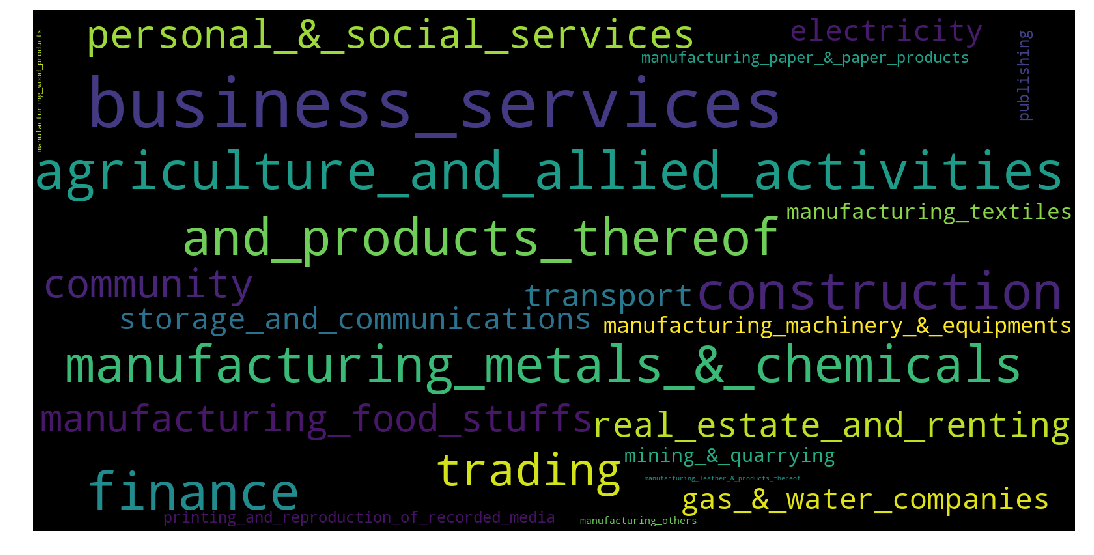

In [13]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='black',
                      width= 1600, height= 800,
                      min_font_size = 10).generate_from_frequencies(my_dict)
fig = plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

**The top 15 tags**

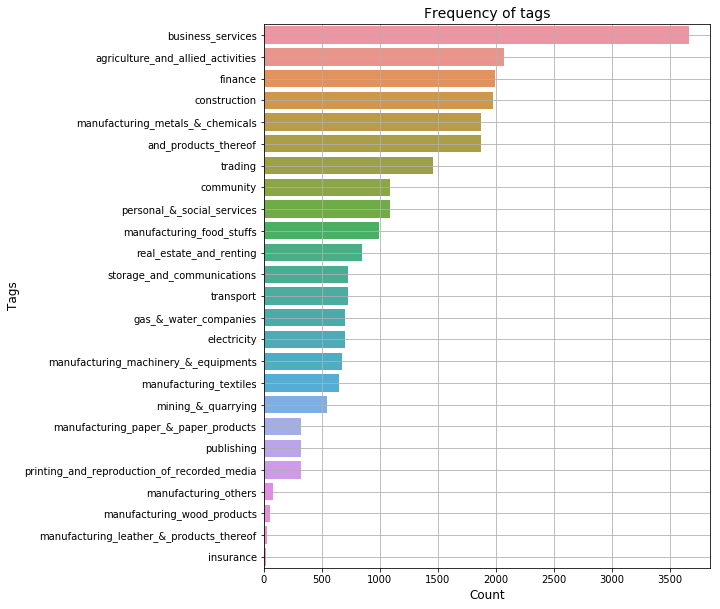

In [14]:
cnt_tags = pd.DataFrame(my_dict.items(), columns = ["tags", "count"])
cnt_tags.sort_values(["count"],  ascending=False, inplace=True)
cnt_tags.reset_index(drop=True, inplace=True)

plt.figure(figsize = (8,10))
sns.barplot(x = 'count', y = 'tags', data = cnt_tags)
plt.title('Frequency of tags', fontsize = 14)
plt.xlabel('Count', fontsize = 12)
plt.ylabel('Tags', fontsize = 12)
plt.grid(1)
plt.show()

### **DATE_OF_REGISTRATION**

**Convert `DATE_OF_REGISTRATION` into pandas `datetime` type.**

In [15]:
def process_datetime(x):
    x = x.split(" ")[0].replace("-", "/") #to keep dd/mm/yy
    year = int(x.split("/")[2])
    if year<2000 and year<20:
        year = 2000+year
    elif year>=20 and year<100:
        year = 1900+year
    x = x.split("/")
    x.pop(2)
    x.append(str(year))
    return "/".join(x)

new_df["DATE_OF_REGISTRATION"] = new_df["DATE_OF_REGISTRATION"].apply(process_datetime)
new_df["DATE_OF_REGISTRATION"] = pd.to_datetime(new_df['DATE_OF_REGISTRATION'], format="%d/%m/%Y")
new_df.shape

(19779, 8)

In [16]:
a = new_df.groupby(["DATE_OF_REGISTRATION"])\
          .agg({'COMPANY_NAME': 'count'})\
         .reset_index()\
         .rename(columns={'COMPANY_NAME':'count'})
a["year"] = a["DATE_OF_REGISTRATION"].dt.year
a = a.groupby("year").agg({"count":'sum'}).reset_index()

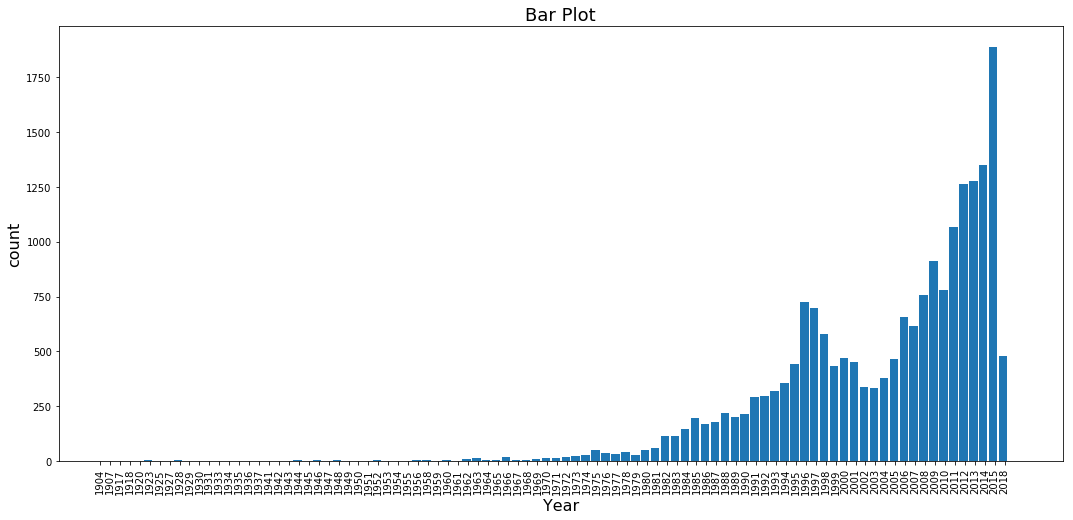

In [17]:
cnts = a["count"].values
labels = a["year"].values
x = np.arange(0,len(labels))  # the label locations
width = 0.85  # the width of the bars

fig, ax = plt.subplots(figsize = (18,8))
rects1 = ax.bar(x+width, cnts, width)
ax.set_title('Bar Plot', fontsize=18)
ax.set_ylabel('count',  fontsize=16)
ax.set_xlabel('Year',  fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation = 90,  fontsize=10)


plt.show()

* From above it can be seen that the number of registered company per year follow skewed (right) distribution.
* There are very few companies per year before 1981.
* Number of companies per year was on peak in 1997 and then again there was reduction till 2003.
* After 2003 there is a large change in the number of companies per year.

# 4. **Time Based Split**
* Use `DATE_OF_REGISTRATION` to split the data.
* Let's take all datapoints before 2014 for training and from 2014 to reamiming data testing.

In [18]:
train_df = new_df[new_df["DATE_OF_REGISTRATION"]<="2013/12/31"]
test_df  = new_df[new_df["DATE_OF_REGISTRATION"]>"2013/12/31"]

#now drop the `DATE_OF_REGISTRATION` column because it is no more needed.
train_df.drop(['DATE_OF_REGISTRATION'], axis=1, inplace=True)
test_df.drop(['DATE_OF_REGISTRATION'], axis=1, inplace=True)

Y_train = train_df["PRINCIPAL_BUSINESS_ACTIVITY"]
Y_test  = test_df["PRINCIPAL_BUSINESS_ACTIVITY"]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


**Converting Tags into binary vectors**

In [19]:
Y_train = vect.transform(Y_train)
Y_test = vect.transform(Y_test)

print("Y_train shape: ", Y_train.shape)
print("Y_test shape: ", Y_test.shape)
print("There are total {} tags in the training dataset.".format(Y_train.shape[1]))

Y_train shape:  (17414, 25)
Y_test shape:  (2365, 25)
There are total 25 tags in the training dataset.


### Processing the `Categorical` features
1. 'COMPANY_STATUS',
2. 'COMPANY_CLASS', 
* 'COMPANY_CATEGORY', 
* 'REGISTRAR_OF_COMPANIES',
* 'SUB_CATEGORY'

In [20]:
def process_name(name):
    name = name.lower()
    # replace every special char with space
    name = re.sub('[^a-zA-Z0-9\n]', ' ', name)
    # replace multiple spaces with single space
    name = re.sub('\s+',' ', name)
    ls = []
    for i in name.split():
        if i not in StopWords:
            ls.append(i)
    return " ".join(ls)

train_df.loc[:, "COMPANY_NAME"] = train_df["COMPANY_NAME"].apply(process_name)
test_df.loc[:, "COMPANY_NAME"]  = test_df["COMPANY_NAME"].apply(process_name)


cols = ['COMPANY_STATUS', 'COMPANY_CLASS', 'COMPANY_CATEGORY', 'REGISTRAR_OF_COMPANIES', 'SUB_CATEGORY']
for col in cols:
    train_df.loc[:, col] = train_df[col].apply(lambda x: "_".join(x.lower().split( )))
    test_df.loc[:, col]  = test_df[col].apply(lambda x: "_".join(x.lower().split( )))
    
total_features = 0
print("Column Name", " "*20, "#unique Values")
print()
for col in cols:
    n = len(train_df[col].unique())
    print(col, " "*(40-len(col)), n)
    total_features += n
print("Total number of dimensions due to these columns: ", total_features)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Column Name                      #unique Values

COMPANY_STATUS                            8
COMPANY_CLASS                             2
COMPANY_CATEGORY                          3
REGISTRAR_OF_COMPANIES                    2
SUB_CATEGORY                              7
Total number of dimensions due to these columns:  22


### Vectorization

In [21]:
cols = ["COMPANY_NAME"] + cols
X_train = train_df[cols]
X_test  = test_df[cols]

vectorizer_dict = dict()
tr = []
te = []
for col in X_train.columns:
    if col != "COMPANY_NAME":
        vectorizer = CountVectorizer(stop_words = "english", lowercase=True)
        train = vectorizer.fit_transform(X_train[col])
        test = vectorizer.transform(X_test[col])
        vectorizer_dict[col] = vectorizer
        tr.append(train)
        te.append(test)
    else:
        vectorizer = CountVectorizer(stop_words = "english", lowercase=True,
                                    max_features = 2500)
        train = vectorizer.fit_transform(X_train[col])
        test = vectorizer.transform(X_test[col])
        vectorizer_dict[col] = vectorizer
        tr.append(train)
        te.append(test)

### Stacking

In [22]:
xtrain = hstack((tr[0], tr[1], tr[2], tr[3],tr[4],tr[5])).tocsr()
xtest  = hstack((te[0], te[1], te[2], te[3],te[4],te[5])).tocsr()

print("Train X-shape: {} and Y-train shape: {}".format(xtrain.shape, Y_train.shape))
print("Test X-shape: {} and Y-test shape: {}".format(xtest.shape, Y_test.shape))

Train X-shape: (17414, 2523) and Y-train shape: (17414, 25)
Test X-shape: (2365, 2523) and Y-test shape: (2365, 25)


# 5. ML Models 

## 5.1 Random Model (very poor model)

* Let's make a random model and perforamnce of this model will be used as threshold. Any reasonable model must give better perfromance than this model.

In [23]:
Y_train_pred = np.zeros(Y_train.shape)
Y_test_pred = np.zeros(Y_test.shape)
d = Y_train.shape[1]

for i in range(Y_train.shape[0]):
    Y_train_pred[i] = np.random.randint(0,2,d)
    
for i in range(Y_test.shape[0]):
    Y_test_pred[i] = np.random.randint(0,2,d)
    
print("Train f1-score (micro): {:.4f}".format(f1_score(Y_train, Y_train_pred, average='micro')))
print("Test f1-score (micro): {:.4f}".format(f1_score(Y_test, Y_test_pred, average='micro')))

Train f1-score (micro): 0.0913
Test f1-score (micro): 0.0850


* So any reasonable model must have f1-score greater than 0.09 for train and test both.

## 5.2 Naive Bayes ([MultiNomial](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB))

In [58]:
from sklearn.naive_bayes import MultinomialNB
# https://stackoverflow.com/a/12637528/12005970
params = {"estimator__alpha":[i/10 for i in range(10)]+
                             [i/100 for i in range(1,10)]+
                             [10**i for i in range(-7,-3)]}

est = OneVsRestClassifier(MultinomialNB())
search = RandomizedSearchCV(est, params, n_iter=20,scoring='f1_micro', n_jobs = -1,
                            cv=5, random_state = 42, verbose = 1)
search.fit(xtrain, Y_train)

print("Best validation f1-score (micro): ", search.best_score_)
model = search.best_estimator_
print("Best estimator: ", model)

print("\n\nTraining the best model....")
model.fit(xtrain, Y_train)

Y_train_pred = model.predict(xtrain)
Y_test_pred  = model.predict(xtest)
print("Train f1-score (micro): {:.4f}".format(f1_score(Y_train, Y_train_pred, average='micro')))
print("Test f1-score (micro): {:.4f}".format(f1_score(Y_test, Y_test_pred, average='micro')))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished


Best validation f1-score (micro):  0.6219538631019924
Best estimator:  OneVsRestClassifier(estimator=MultinomialNB(alpha=0.2, class_prior=None,
                                            fit_prior=True),
                    n_jobs=None)


Training the best model....
Train f1-score (micro): 0.7543
Test f1-score (micro): 0.6233


## 5.3 Logistic Regression

In [61]:
params = {"estimator__penalty": ["l1", "l2", "elasticnet’"],
          "estimator__C": [i/10 for i in range(10)]+[i/100 for i in range(1,10)]+
                          [10**i for i in range(-7,-3)]+[i for i in range(1,10)]+
                          [10**i for i in range(2,5)]}

est = OneVsRestClassifier(LogisticRegression(solver = "liblinear", max_iter=300))
search = RandomizedSearchCV(est, params, n_iter=20,scoring='f1_micro', n_jobs = -1,
                            cv=5, random_state = 42, verbose = 1)
search.fit(xtrain, Y_train)

print("Best validation f1-score (micro): ", search.best_score_)
model = search.best_estimator_
print("Best estimator: ", model)

print("\n\nTraining the best model....")
model.fit(xtrain, Y_train)

Y_train_pred = model.predict(xtrain)
Y_test_pred  = model.predict(xtest)
print("Train f1-score (micro): {:.4f}".format(f1_score(Y_train, Y_train_pred, average='micro')))
print("Test f1-score (micro): {:.4f}".format(f1_score(Y_test, Y_test_pred, average='micro')))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished


Best validation f1-score (micro):  0.6574137343599536
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=9, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=300,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)


Training the best model....
Train f1-score (micro): 0.8073
Test f1-score (micro): 0.6084


## 5.4 [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [64]:
params = {"estimator__gamma": ["auto", "scale’"],
          "estimator__C": [i/10 for i in range(10)]+[i/100 for i in range(1,10)]+
                          [10**i for i in range(-7,-3)]+[i for i in range(1,10)]+
                          [10**i for i in range(2,5)],
         "estimator__degree": [3,4,5]}

est = OneVsRestClassifier(SVC(class_weight="balanced", kernel="rbf"))
search = RandomizedSearchCV(est, params, n_iter=10,scoring='f1_micro', n_jobs = -1,
                            cv=5, random_state = 42, verbose = 1)
search.fit(xtrain, Y_train)

print("Best validation f1-score (micro): ", search.best_score_)
model = search.best_estimator_
print("Best estimator: ", model)

print("\n\nTraining the best model....")
model.fit(xtrain, Y_train)

Y_train_pred = model.predict(xtrain)
Y_test_pred  = model.predict(xtest)
print("Train f1-score (micro): {:.4f}".format(f1_score(Y_train, Y_train_pred, average='micro')))
print("Test f1-score (micro): {:.4f}".format(f1_score(Y_test, Y_test_pred, average='micro')))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 130.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 153.2min finished


Best validation f1-score (micro):  0.5733031066899703
Best estimator:  OneVsRestClassifier(estimator=SVC(C=100, break_ties=False, cache_size=200,
                                  class_weight='balanced', coef0=0.0,
                                  decision_function_shape='ovr', degree=5,
                                  gamma='auto', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)


Training the best model....
Train f1-score (micro): 0.6333
Test f1-score (micro): 0.5260


## 5.5 [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [68]:
params = {"estimator__n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500],
         "estimator__max_depth": [3, 5, 7, 10, 12, 15, 17, 20, 25],
         "estimator__min_samples_split": [2,5,7,10,12,15,20],
         "estimator__max_features": ["auto", "sqrt", "log2"]}

est = OneVsRestClassifier(RandomForestClassifier(class_weight="balanced"))
search = RandomizedSearchCV(est, params, n_iter=20,scoring='f1_micro', n_jobs = -1,
                            cv=5, random_state = 42, verbose = 1)
search.fit(xtrain, Y_train)

print("Best validation f1-score (micro): ", search.best_score_)
model = search.best_estimator_
print("Best estimator: ", model)

print("\n\nTraining the best model....")
model.fit(xtrain, Y_train)

Y_train_pred = model.predict(xtrain)
Y_test_pred  = model.predict(xtest)
print("Train f1-score (micro): {:.4f}".format(f1_score(Y_train, Y_train_pred, average='micro')))
print("Test f1-score (micro): {:.4f}".format(f1_score(Y_test, Y_test_pred, average='micro')))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 55.1min finished


Best validation f1-score (micro):  0.5440904637003965
Best estimator:  OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight='balanced',
                                                     criterion='gini',
                                                     max_depth=25,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=12,
                                                   

**Model Performance Summary**

|Model|Train f1-score|Test f1-score|
|-----|--------------|-------------|
|Naive Bayes|0.7543|0.6233|
|Logistic Regression|0.8073|0.6084|
|SVM|0.6333|0.5260|
|Random Forest|0.6247|0.5665|

* Out of above models **Naive Bayes** Model is giving best performance.

In [40]:
from sklearn.metrics import classification_report

best_model = OneVsRestClassifier(estimator=MultinomialNB(alpha=0.2, class_prior=None,fit_prior=True))
best_model.fit(xtrain, Y_train)

Y_train_pred = model.predict(xtrain)
Y_test_pred  = model.predict(xtest)
print("Train f1-score (micro): {:.4f}".format(f1_score(Y_train, Y_train_pred, average='micro')))
print("Test f1-score (micro): {:.4f}".format(f1_score(Y_test, Y_test_pred, average='micro')))

print("Model report: \n")
print(classification_report(Y_test, Y_test_pred, target_names = vect.get_feature_names(), zero_division=0))

Train f1-score (micro): 0.7574
Test f1-score (micro): 0.6193
Model report: 

                                             precision    recall  f1-score   support

          agriculture_and_allied_activities       0.80      0.65      0.72       172
                       and_products_thereof       0.57      0.42      0.48       128
                          business_services       0.81      0.66      0.73       897
                                  community       0.36      0.47      0.40       101
                               construction       0.68      0.75      0.71       280
                                electricity       0.76      0.76      0.76       118
                                    finance       0.92      0.84      0.88        69
                      gas_&_water_companies       0.76      0.76      0.76       118
                                  insurance       0.00      0.00      0.00         0
                  manufacturing_food_stuffs       0.60      0.36      0.